# $K^+ \to \pi^+ \gamma X$

### branching ratio

In [1]:
import matplotlib.pyplot as plt

from matplotlib.pylab import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import sys
sys.path.append('../')
from alplib.constants import *
from alplib.fmath import *


KAPPA = 7.35e-8
r = (M_PI/M_K)**2

def dGamma_dxdy(y, x, gKPI, mX):
    prefactor = KAPPA**2 * ALPHA * M_K**3 / (16 * pi**2) / mX**2

    rX = (mX / M_K)**2
    x_pi_gamma = (M_K**2 + mX**2 + M_PI**2 - x - y) / M_K**2
    N0 = x_pi_gamma*y - r**2 * (1 - x_pi_gamma * (1 - 2 * y))
    D1 = r - x_pi_gamma
    D2 = r + rX - x_pi_gamma - x

    return prefactor * gKPI**2 * x * (N0) / (D1**2 * D2**2)

def dGamma_dx(x, gKPI, mX):
    E3star = (M_K**2 * (1 - x) - M_PI**2)/(2 * M_K * sqrt(x))
    E2star = (M_K**2 * x + mX**2)/(2 * M_K * sqrt(x))

    m23_max = (E2star + E3star)**2 - np.power(sqrt(E2star**2 - mX**2) - sqrt(E3star**2 - M_PI**2), 2)
    m23_min = (E2star + E3star)**2 - np.power(sqrt(E2star**2 - mX**2) + sqrt(E3star**2 - M_PI**2), 2)
    y_min = m23_min / M_K**2
    y_max = m23_max / M_K**2

    integral = quad(dGamma_dxdy, y_min, y_max, args=(x, gKPI, mX))[0]
    return integral

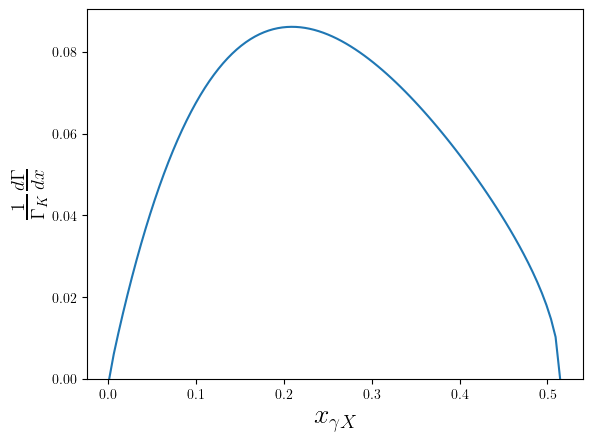

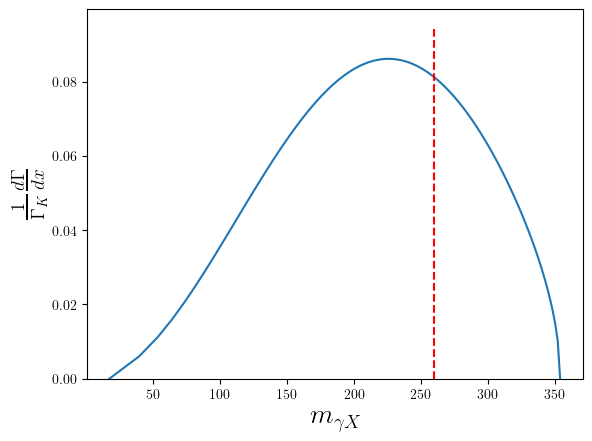

In [62]:
test_mX = 17.0

x_min = test_mX**2 / M_K**2
x_max = (M_K - M_PI)**2 / M_K**2

x_vals = np.linspace(x_min, x_max, 100)

dGamma_dx_vals = [dGamma_dx(x, 1.0, test_mX)/KAON_WIDTH for x in x_vals]

plt.plot(x_vals, dGamma_dx_vals)
plt.ylabel(r"$\frac{1}{\Gamma_K}\frac{d \Gamma}{d x}$ ", fontsize=20)
plt.xlabel(r"$x_{\gamma X}$", fontsize=20)
plt.ylim(bottom=0.0)
plt.show()


plt.plot(sqrt(x_vals * M_K**2), dGamma_dx_vals)
plt.ylabel(r"$\frac{1}{\Gamma_K}\frac{d \Gamma}{d x}$ ", fontsize=20)
plt.xlabel(r"$m_{\gamma X}$", fontsize=20)
plt.vlines(260.0, ymin=0.0, ymax=1.1*max(dGamma_dx_vals), colors='red', linestyles='dashed')
plt.ylim(bottom=0.0)
plt.show()

### NA48/2 analysis

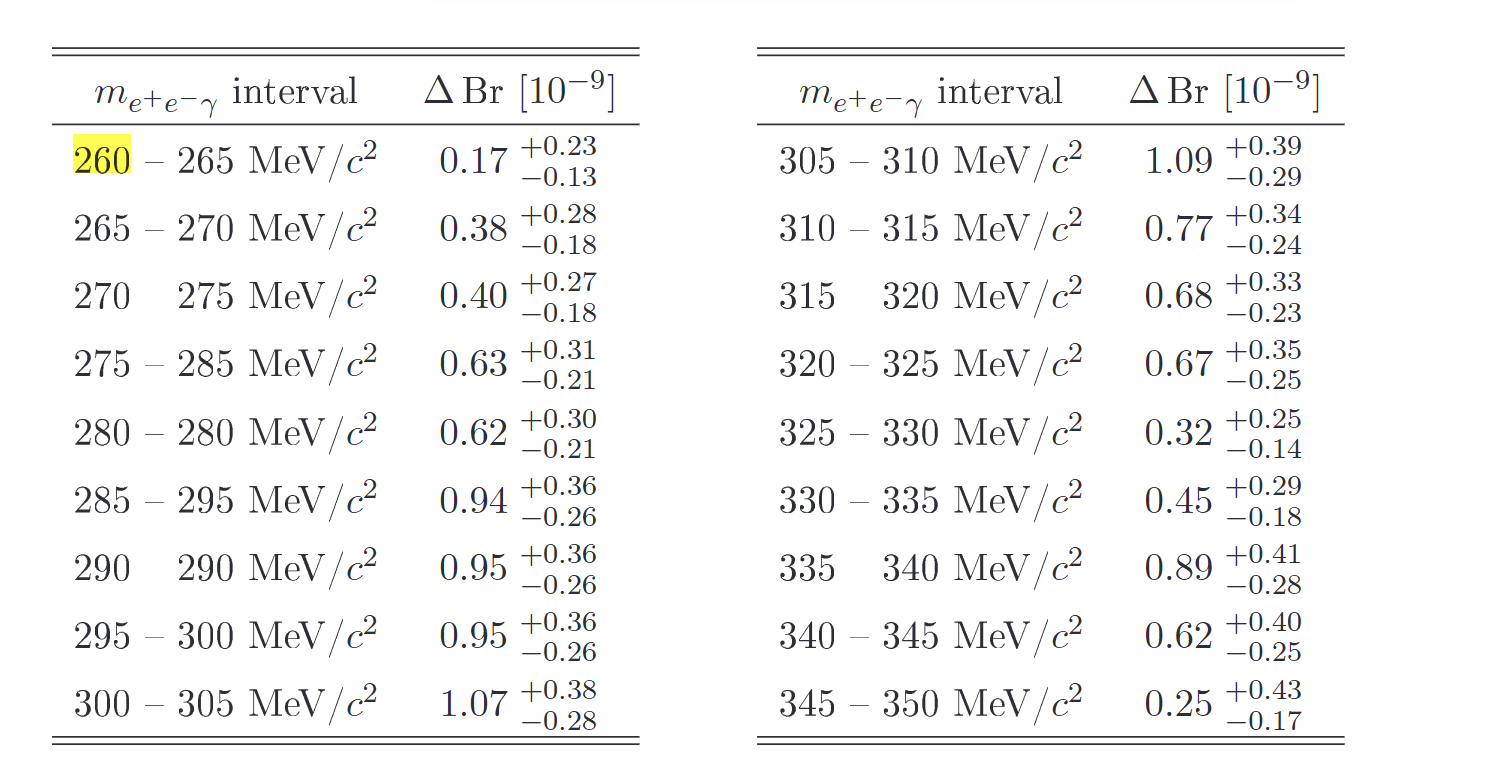

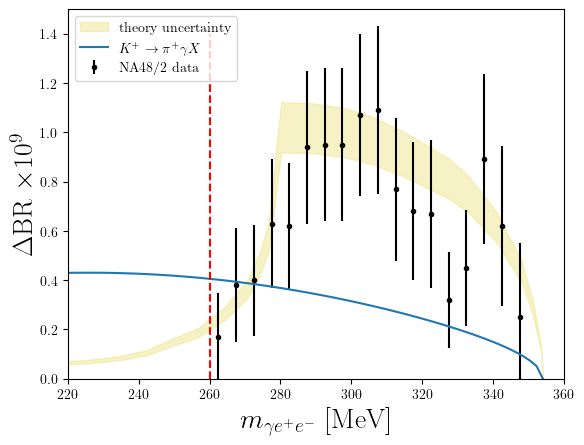

In [68]:
br_uperrors_NA48 = 1e-9 * np.array([0.23, 0.28, 0.27, 0.31, 0.3, 0.36, 0.36, 0.36, 0.38, 0.39, 0.34, 0.33, 0.35,
                                  0.25, 0.29, 0.41, 0.40, 0.43])
br_downerrors_NA48 = 1e-9 * np.array([0.13, 0.18, 0.18, 0.21, 0.21, 0.26, 0.26, 0.26, 0.28, 0.29, 0.24, 0.23, 0.25,
                                  0.14, 0.18, 0.28, 0.25, 0.17])
br_bins_NA48 = np.array([260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350])
br_bin_centers_NA48 = 0.5 * (br_bins_NA48[:-1] + br_bins_NA48[1:])
br_vals_NA48 = 1e-9 * np.array([0.17, 0.38, 0.40, 0.63, 0.62, 0.94, 0.95, 0.95, 1.07, 1.09, 0.77, 0.68,
                                0.67, 0.32, 0.45, 0.89, 0.62, 0.25])

errorbars = (br_uperrors_NA48 + br_downerrors_NA48)/2

# theory
theory_dat = np.genfromtxt("data/NA48/KPlus_Gamma_ee_meegamma_deltaBR.txt")

plt.fill_between(theory_dat[:,0], y1=1.1*theory_dat[:,1], y2=0.9*theory_dat[:,1],
                 color='khaki', alpha=0.5, label='theory uncertainty')
plt.errorbar(br_bin_centers_NA48, 1e9*br_vals_NA48, yerr=1e9*errorbars, marker='.',
             linestyle='none', color='black', label='NA48/2 data')
plt.plot(sqrt(x_vals * M_K**2), 5.0*np.array(dGamma_dx_vals), label=r"$K^+ \to \pi^+ \gamma X$")

plt.vlines(260.0, ymin=0.0, ymax=1.4, colors='red', linestyles='dashed')


plt.ylim((0.0, 1.5))
plt.xlim((220.0, 360.0))
plt.ylabel(r"$\Delta$BR $\times 10^{9}$", fontsize=20)
plt.xlabel(r"$m_{\gamma e^+ e^-}$ [MeV]", fontsize=20)
plt.legend(loc="upper left")
plt.show()

### $\chi^2$ analysis and mass scan

In [69]:
test_mx_vals = np.linspace(1.0, 120.0, 300)
test_couplings = np.logspace(-8, -1, 300)

null_hypothesis_points = 1e-9 * np.interp(br_bin_centers_NA48, theory_dat[:,0], theory_dat[:,1])

mX_list = []
g_list = []
chi2_list = []

for mX in test_mx_vals:
    x_vals = br_bin_centers_NA48**2 / M_K**2  # from 260 to 350
    deltax = x_vals[1] - x_vals[0]

    integrated_brs = np.array([deltax * dGamma_dx(x, 1.0, mX) / KAON_WIDTH for x in x_vals])

    for g in test_couplings:
        signal = g**2 * integrated_brs
        error_total = sqrt(errorbars**2 + (0.1 * null_hypothesis_points)**2)

        chi2 = np.sum(np.power(null_hypothesis_points + signal - br_vals_NA48, 2) / error_total**2)

        mX_list.append(mX)
        g_list.append(g)
        chi2_list.append(chi2)


out_array = np.array([mX_list, g_list, chi2_list]).T
np.savetxt("limits/NA48_KtoGammaPiX_ee_chi2_grid.txt", out_array)


In [57]:
print(integrated_brs)
print(deltax)

[1.71553836e-05 1.69046526e-05 1.66006596e-05 1.62438522e-05
 1.58345992e-05 1.53731405e-05 1.48595209e-05 1.42934980e-05
 1.36744131e-05 1.30010044e-05 1.22711252e-05 1.14813025e-05
 1.06260067e-05 9.69636471e-06 8.67768718e-06 7.54413937e-06
 6.24510433e-06 4.65854820e-06]
0.010873267822466393


# Combined plot

<>:161: SyntaxWarning: invalid escape sequence '\p'
<>:161: SyntaxWarning: invalid escape sequence '\p'
C:\Users\adria\AppData\Local\Temp\ipykernel_41864\3793799588.py:161: SyntaxWarning: invalid escape sequence '\p'
  """


912606923360476.5


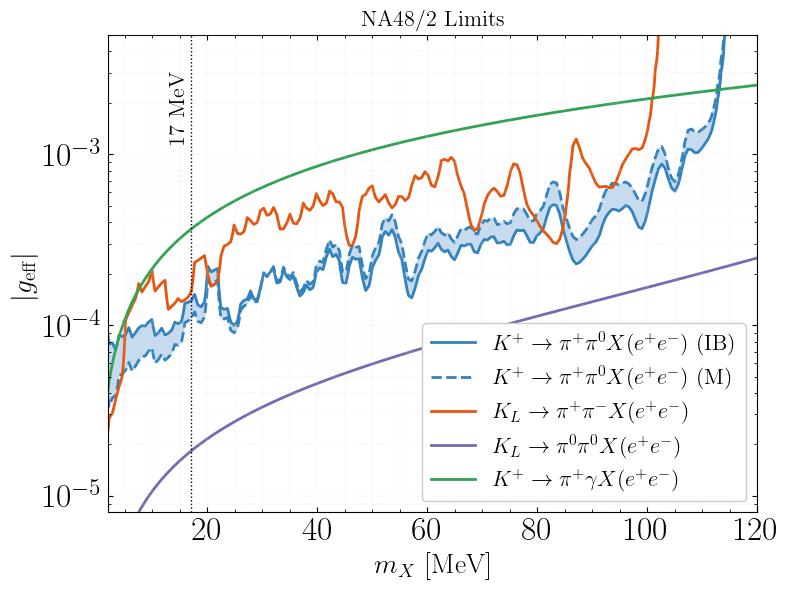

In [ ]:
from matplotlib.lines import Line2D
cmap = plt.get_cmap('tab20')


###################################################
# Load in all the limits

# K -> pi0 pi0
KTeV_KL_to_pi0pi0_limits = np.genfromtxt("limits/KTeV_KL_pi0pi0_X_limits.txt")


###################################################
# K+ to Pi+ gamma X limits
chi2_dat_KPlusGammaX = np.genfromtxt("limits/NA48_KtoGammaPiX_ee_chi2_grid.txt")

m_dat_rad = chi2_dat_KPlusGammaX[:,0]
g_dat_rad = chi2_dat_KPlusGammaX[:,1]

m_unique_rad = np.unique(m_dat_rad)
# look in slices of constant m and subtract the min chi2 value
for m in m_unique_rad:
    mask = (m_dat_rad == m)
    chi2_dat_KPlusGammaX[mask,2] = chi2_dat_KPlusGammaX[mask,2] - min(chi2_dat_KPlusGammaX[mask,2])


chi2_Kplus_rad = chi2_dat_KPlusGammaX[:,2]
print(max(chi2_Kplus_rad))


###################################################
# K+ to Pi+ Pi0 limits
chi2_dat = np.genfromtxt("limits/NA48-2_KPlus_limits.txt")

m_dat = chi2_dat[:,0]
g_dat = chi2_dat[:,1]

m_unique = np.unique(m_dat)
# look in slices of constant m and subtract the min chi2 value
for m in m_unique:
    mask = (m_dat == m)
    chi2_dat[mask,2] = chi2_dat[mask,2] - min(chi2_dat[mask,2])
    chi2_dat[mask,3] = chi2_dat[mask,3] - min(chi2_dat[mask,3])
    chi2_dat[mask,4] = chi2_dat[mask,4] - min(chi2_dat[mask,4])

ib_chi2 = chi2_dat[:,2]
m_chi2 = chi2_dat[:,4]

###################################################
# KL to Pi+ Pi- limits
chi2_dat_KLpippim = np.genfromtxt("limits/NA48-2_KL_pip_pim_limits_recalc.txt")

m_dat_2 = chi2_dat_KLpippim[:,0]
g_dat_2 = chi2_dat_KLpippim[:,1]

m_unique_2 = np.unique(m_dat_2)
# look in slices of constant m and subtract the min chi2 value
for m in m_unique_2:
    mask = (m_dat_2 == m)
    chi2_dat_KLpippim[mask,2] = chi2_dat_KLpippim[mask,2] - min(chi2_dat_KLpippim[mask,2])


chi2_KLpippim = chi2_dat_KLpippim[:,2]


###################################################
# Combine the limits and plot

# K+
MX, G = np.meshgrid(np.unique(m_dat),np.unique(g_dat))
CHI2_IB = np.reshape(ib_chi2, (np.unique(m_dat).shape[0],np.unique(g_dat).shape[0]))
CHI2_M = np.reshape(m_chi2, (np.unique(m_dat).shape[0],np.unique(g_dat).shape[0]))

# K+ rad
MX_RAD, G_RAD = np.meshgrid(np.unique(m_dat_rad),np.unique(g_dat_rad))
CHI2_RAD = np.reshape(chi2_Kplus_rad, (np.unique(m_dat_rad).shape[0],np.unique(g_dat_rad).shape[0]))

# KL
MX2, G2 = np.meshgrid(np.unique(m_dat_2),np.unique(g_dat_2))
CHI2_KL_PIP_PIM = np.reshape(chi2_KLpippim, (np.unique(m_dat_2).shape[0],np.unique(g_dat_2).shape[0]))

CL = 2.3
CL2_1PARAM = 9.0
CL2 = 6.18
CL3 = 11.83



###################################################
# Begin figure

colors = [cmap(0), cmap(2), cmap(4), cmap(6), cmap(8), cmap(10)]
box_colors = [cmap(1), cmap(3), cmap(5), cmap(7), cmap(9), cmap(11)]

fig, ax = plt.subplots(figsize=(8,6))    

y_min = 8e-6
y_max = 5e-3

###################################################
# Plot contours and lines for limits for K+ and KL

# KL to pi0 pi0
ax.plot(KTeV_KL_to_pi0pi0_limits[:,0], KTeV_KL_to_pi0pi0_limits[:,1],
        color=cmap(12), linewidth=2.0, linestyle='solid')

# K+ to pi+ pi0
c_ib = ax.contour(MX, G, CHI2_IB.transpose(),
                    levels=[CL2_1PARAM], colors=[colors[0]],
                    alpha=1.0, linewidths=2.0, linestyles=['solid'])

c_m = ax.contour(MX, G, CHI2_M.transpose(),
                    levels=[CL2_1PARAM], colors=[colors[0]],
                    alpha=1.0, linewidths=2.0, linestyles=['dashed'])

# KL to pi+ pi-
c_kl = ax.contour(MX2, G2, CHI2_KL_PIP_PIM.transpose(),
                    levels=[CL2_1PARAM], colors=[colors[1]], alpha=1.0, linewidths=2.0, linestyles=['solid'])

# K+ to gamma pi X
c_rad = ax.contour(MX_RAD, G_RAD, CHI2_RAD.transpose(),
                    levels=[CL2], colors=[colors[2]],
                    alpha=1.0, linewidths=2.0, linestyles=['solid', 'dashed', 'dotted', 'dotted'])


# fill between two contour lines
def extract_contour_paths(contour_obj):
    polygons = []
    for seg in contour_obj.allsegs[0]:
        tmp_x = seg[:,0]
        tmp_y = seg[:,1]
    return polygons

c_m_lines_x = c_m.allsegs[0][0][:,0]
c_m_lines_y = c_m.allsegs[0][0][:,1]
c_ib_lines_x = c_ib.allsegs[0][0][:,0]
c_ib_lines_y = c_ib.allsegs[0][0][:,1]

# extract paths from contour
def interp_m(mX):
    return np.interp(mX, c_m_lines_x, c_m_lines_y)

def interp_ib(mX):
    return np.interp(mX, c_ib_lines_x, c_ib_lines_y)

mX_vals = np.linspace(0.0, 120.0, 1000)

plt.fill_between(mX_vals, interp_m(mX_vals), interp_ib(mX_vals), color=cmap(3))


# Plot markers and text
ax.vlines(17.0, ymin=y_min, ymax=y_max, linewidth=1.0, color='k', alpha=1.0, linestyle='dotted')
ax.text(13.0, 1.2e-3, "17 MeV", rotation=90.0, fontsize=16)

ax.set_yscale('log')
ax.set_title(r"NA48/2 Limits", fontsize=16)
ax.set_xlabel(r"$m_X$ [MeV]", fontsize=20)
#ax.set_ylabel(r"$|2 g_u^A + g_d^A + g_s^A|$", fontsize=20)
ax.set_ylabel(r"$|g_{\rm eff}|$", fontsize=20)

# text boxes
# $g_{\rm eff} = 5 g_d^A + g_s^A - 2 g_u^A$  K+
#  2 g_u^A + g_d^A + g_s^A K_L pi+ pi-

"""
ax.text(40, 1.5e-3, r"$g_{\rm eff} = g_{K\pi^+\pi^-}^X$",
        fontsize=16, bbox=dict(boxstyle='round', facecolor=cmap(7), alpha=1.0))
ax.text(28, 8e-5, r"$g_{\rm eff} = g_{K\pi^+\pi^0}^X$",
        fontsize=16, bbox=dict(boxstyle='round', facecolor=cmap(3), alpha=1.0))
ax.text(23, 1.4e-5, r"$g_{\rm eff} = g_{K\pi^0 \pi^0}^X$",
        fontsize=16, bbox=dict(boxstyle='round', facecolor=cmap(14), alpha=1.0))
"""
# on $K^\pm \to \pi^\pm \pi^0 X(e^+ e^-)$

# Set the grids
ax.grid(True, linestyle='--', which="both", linewidth=0.2, alpha=1.0, color='gainsboro')
ax.minorticks_on()

# Major ticks (all sides)
ax.tick_params(axis='both', which='major',
            direction='in',
            labelsize=24,
            top=True, bottom=True, left=True, right=True)

# Minor ticks (all sides)
ax.tick_params(axis='both', which='minor',
            direction='in',
            top=True, bottom=True, left=True, right=True)
ax.set_axisbelow(False)  # <-- added


custom_lines = [Line2D([0], [0], color=colors[0], lw=2.0),
                Line2D([0], [0], color=colors[0], ls='dashed', lw=2.0),
                Line2D([0], [0], color=colors[1], lw=2.0),
                Line2D([0], [0], color=colors[3], lw=2.0),
                Line2D([0], [0], color=colors[2], lw=2.0)]

ax.set_ylim((y_min, y_max))
ax.set_xlim((2.0,120.0))
plt.legend(custom_lines, [r'$K^+ \to \pi^+ \pi^0 X(e^+ e^-)$ (IB)',
                          r'$K^+ \to \pi^+ \pi^0 X(e^+ e^-)$ (M)',
                          r"$K_L \to \pi^+ \pi^- X(e^+ e^-)$",
                          r"$K_L \to \pi^0 \pi^0 X(e^+ e^-)$",
                          r"$K^+ \to \pi^+ \gamma X(e^+ e^-)$"],
                          framealpha=1.0, loc="lower right", fontsize=16)

plt.tight_layout()
#plt.savefig("plots/NA48_combined_limits_mX_v2.pdf")
plt.show()

